# Transform collected YouTube Files to Trainingsdata
We want to use two kinds of trainingdata. First we want to split every song in junks of circa 0.5 seconds and use them as trainingsdata to generate new junks. These junks get sorted in a 2 dimensional field by our autoencoder. The structure of a song can then be imagened as a movement trough the 2 dimensional field. We will store these "movements", i.e. a list of coordinates and use these lists as trainingsdata for another network. Finally we want to be able to generate new "movements", i.e. new sequences of waveset-junks on the one hand and the corresponding junks themselves on the other hand.

## Wavesets
Every track from the training data gets split in wavesets with a duration of aprox. 0.2 second.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import librosa
import librosa.display
import librosa.feature.inverse
import soundfile
from IPython.display import display, Audio
import math
import os

### Waveset class
We split each song in multiple wavesets and create spectograms of them.
To train the autoencoder all spectograms have to be of the same size and have an even number of time-windows. The wavesets are of variable length, because the zero-crossing is a contigent feature. We can't be sure that all spectograms have the same number of time-windows. We have to check and pad if necessary:

In [2]:
a = 44100 *60* 5.32
len_of_splits = 44100/4
split_points = np.array(0)
for i in range(int(a/len_of_splits)):
    split_points = np.append(split_points, int((i+1)*(44100/4)))
print(split_points[:10])


[    0 11025 22050 33075 44100 55125 66150 77175 88200 99225]


In [7]:
class Wavesets:
    def __init__(self, file_path, min_size_fraction, win_length, n_fft, hop_length):
            self.data, self.sr = librosa.load(path, sr=None, mono = True)
            self.min_size = self.sr/min_size_fraction
            self.deleted_ws = 0
            self.split_points = []
            self.win_length = win_length
            self.n_fft = n_fft
            self.hop_length = hop_length
    
    def get_waveset_spectos(self):
        self.split_points = self.get_splitPoints()
        wavesets = self.generate_wavesets()
        spectos = self._get_mel_spectos(wavesets)
        normalized_spectos = self._normalise(np.asarray(spectos), 0, 1, -100, 100)
        return normalized_spectos
    
    def get_splitPoints(self):
        split_points = []
        for i in range(int(len(self.data)/self.min_size)):
            split_points.append(int((i+1)*(self.min_size)))
        # split_points = np.argwhere(
        # (np.sign(self.data[:-1])==-1) & (np.sign(self.data[1:])==1)
        # )
        # split_points = self._resize_splits(split_points)
        # self.split_points = split_points
        return split_points
    
    def _resize_splits(self, splits):
        new_splits = []
        last_split = 0
        for split in splits:
            if (split - last_split) > self.min_size:
                last_split = split
                new_splits.append(split)
        return np.array(new_splits)

    def plot_wavesets(self, plot_range=[0, 44100 * 60 * 7]):
        data_range = self.data[plot_range[0]:plot_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data_range)
        plt.hlines(0.0, plot_range[0], plot_range[1], color='r')
        plt.vlines(self.split_points[(plot_range[0]<self.split_points) & (self.split_points<plot_range[1])], data_range.max(), data_range.min(), color='g')
        plt.xlabel("samples")
        plt.ylabel("amplitude")
        plt.title("Wavesets")
        plt.show();
        

    def generate_wavesets(self):
        wavesets = []
        start = 0
        
        for split_point in self.split_points:
            end = split_point
            waveset = self.data[start:(end)]
            waveset = self._apply_padding(waveset,(self.min_size))
            start = end
            if type(waveset) is np.ndarray:
                wavesets.append(waveset)
        
        last_waveset = self.data[start:]
        last_waveset = self._apply_padding(last_waveset, (int(self.min_size + (0.02*self.sr))))
        if type(last_waveset) is np.ndarray:
            wavesets.append(last_waveset)
        return wavesets
    
    def _apply_padding(self, waveset, max_length):
        missing_vals = max_length - waveset.shape[0]
        if missing_vals > 0:
            waveset = np.pad(waveset, (0 , missing_vals), 'constant', constant_values=(0,0))
        return waveset
    
    
    def _get_mel_spectos(self, wavesets):
        spectograms = []
        for ws in wavesets:
            mel = librosa.feature.melspectrogram(y=ws, sr=self.sr, hop_length=self.hop_length, win_length=self.win_length, n_fft=self.n_fft, n_mels=128, fmax=16000)
            spectogram = librosa.power_to_db(mel)
            spectogram = spectogram[... , np.newaxis]
            spectograms.append(spectogram)
        return spectograms
    
    
    def _get_log_spectos(self, wavesets):
        spectograms = []
        for ws in wavesets:
            stft = librosa.stft(ws, hop_length=self.hop_length, n_fft=self.n_fft, win_length=self.win_length)[:-1]
            spectogram = np.abs(stft)
            spectogram = librosa.amplitude_to_db(spectogram)
            spectogram = spectogram[... , np.newaxis]
            spectograms.append(spectogram)
        return spectograms
    
    def _normalise(self, array, new_min, new_max, old_min, old_max):
        norm_array = (array - old_min) / (old_max - old_min)
        norm_array = norm_array * (new_max - new_min) + new_min
        #print(f"Spectogarms original min-value was {array.min()}. Original max-value was {array.max()}")
        #print(f"Spectogarms new min-value is {norm_array.min()}. New max-value is {norm_array.max()}")
        return norm_array

### Generate Wavesets
We can now generate all Wavesets. Later we want to be able to reconstruct the position of each waveset in the song. For this, we store how many wavesets each song is split into.

In [8]:
MIN_SIZE_FRACTION = 4
WIN_LENGTH = 780*2
HOP_LENGTH = 780
N_FFT = 780*2


folder_path = 'D:\\Daten\\Musik\\Fremde\\Ralph Towner'
paths = librosa.util.find_files(folder_path, ext=['wav'])
print(paths[0])

all_wavesets = []
num_of_ws_per_song = []
deleted_wavesets = 0

for i,path in enumerate(paths):
    waveset_generator = Wavesets(path, MIN_SIZE_FRACTION, WIN_LENGTH, N_FFT, HOP_LENGTH)
    wavesets_spectos = waveset_generator.get_waveset_spectos() # The variable "wavesets" is a list spectograms
    deleted_wavesets += waveset_generator.deleted_ws # We count the total number of not used wavesets
    all_wavesets.extend(list(wavesets_spectos))  # all wavesets is a list of all waveset-spectograms
    num_of_ws_per_song.append(len(wavesets_spectos)) # a list of the number of wavesets each song has
    print(f"{i+1} of {len(paths)} songs done." + f" Currently working on file:{path}", end='\r')


D:\Daten\Musik\Fremde\Ralph Towner\Solo Concert\wav\Chelsea Courtyard.wav


In [9]:
print(f"We've extracted {len(all_wavesets)} wavesets out of {len(paths)} songs.")
print(f"We had to delete {deleted_wavesets} wavesets, because they were too long")

We've extracted 7 wavesets out of 7 songs.
We had to delete 11415 wavesets, because they were too long


We can double check, that all spectograms have the same shape:

In [ ]:
for i,ws in enumerate(all_wavesets):
    if not (ws.shape == all_wavesets[0].shape):
        #print("Something went wrong!")
        print(f"{ws.shape[0] - all_wavesets[0].shape[0]} in dim 0 and {ws.shape[1]- all_wavesets[1].shape[1]} in dim 1")
        print(f"Error occured in waveset {i}")
print(f"The wavesets have the shape: {all_wavesets[0].shape}")

We can look at the spectogram of a random waveset to see that everything works.

In [ ]:
librosa.display.specshow(
    all_wavesets[np.random.randint(0,len(all_wavesets))].reshape(all_wavesets[0].shape[0],all_wavesets[0].shape[1]),
    x_axis='time',
    y_axis='mel',
    sr=44100,
    fmax=20000,
    hop_length=HOP_LENGTH,
)
plt.colorbar()
plt.show()

### Create Song-Label for Wavesets
We need another array that stores the information which waveset belongs to which song

In [ ]:
song_labels = np.empty(len(all_wavesets))

start_ws = 0
stop_ws = 0

for i, num_of_ws in enumerate(num_of_ws_per_song):
    stop_ws += num_of_ws
    song_labels[start_ws : stop_ws] = i
    start_ws += num_of_ws
    print(f"{((i+1)/len(num_of_ws_per_song)) * 100}% done", end = "\r")
    

### Create position data
We also want to know, at which position in the song a waveset occured. For this we split the song in 10 parts and create a label 0, 1, 2 or 3 for each waveset.

In [ ]:
song_parts = 10
position_labels = []
for num_of_ws in num_of_ws_per_song:
    position_labels.extend(list(np.linspace(0,song_parts+1, num=num_of_ws, dtype=np.int64)))


### Save Data
We save the data on disk for later use.

In [ ]:
save_folder = "data_and_models\\" + str((1/MIN_SIZE_FRACTION)) + "_" + str(all_wavesets[0].shape[1])

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [ ]:
save_path = save_folder + "\\towner_spectos.npy"
np.save(save_path,np.asarray(all_wavesets))

save_path2 = save_folder + "\\towner_song_labels.npy"
np.save(save_path2, song_labels)

save_path3 = save_folder + "\\towner_labels.npy"
np.save(save_path3, position_labels)

save_path4 = save_folder + "\\towner_WSnum.npy"
np.save(save_path4, num_of_ws_per_song)


## Test the conversion
To see how much of the audio data gets lost in the process of creating the wavesets we can try to reconstruct a song from the generated spectograms. Most information gets lost, because we create a magnitude spectogram and drop the phase information.

In [ ]:
example_pca = None
example_signal = None

def denormalise(array, current_min, current_max, original_min, original_max):
    denorm_array = (array - current_min) / (current_max - current_min)
    denorm_array = denorm_array * (original_max - original_min) + original_min
    return denorm_array

def undo_padding(waveset):
    last_nonzero_element = np.argwhere(np.abs(waveset)>0)
    
    if last_nonzero_element.shape[0] > 0:
        last_nonzero_element = np.max(last_nonzero_element)
        unpad_ws = waveset[:(last_nonzero_element)] 
        return unpad_ws
    else:
        return waveset

def cut_on_last_zero(pca):
    zero_crossings = np.argwhere(
        (np.sign(pca[:-1])==-1) & (np.sign(pca[1:])==1)
        )
    last_zero = zero_crossings[-1][0]
    first_zero = zero_crossings[0][0]
    cutted_pca = pca[first_zero:last_zero]
    return cutted_pca
    
def reconstruct_pca(waveset_spectos):
    reconstructed_data = []
    for i, specto in enumerate(waveset_spectos):
        reshaped_specto = specto[:,:,0]
        denorm_specto = denormalise(reshaped_specto,0,1,-100,100) #reshaped_specto#
        lin_specto = librosa.db_to_power(denorm_specto) #denorm_specto#
        pca = librosa.feature.inverse.mel_to_audio(lin_specto, sr=44100, hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)
        #pca = librosa.feature.inverse.mel_to_audio(lin_specto,sr=44100, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
        signal = cut_on_last_zero(pca)
        reconstructed_data.extend(signal)
        print(f"Reconstructed {i+1} of {len(waveset_spectos)} wavesets", end="\r")
    return reconstructed_data

def get_wavesets_of_song(song_index):
    indices = np.argwhere(song_labels == song_index)
    song_spectos = all_wavesets[indices[0][0]:indices[-1][0]]
    return song_spectos 

In [ ]:
song_num = 0
original_song, _ = librosa.load(paths[song_num],sr=44100, mono=True)
ws = get_wavesets_of_song(song_num)
ws = ws[:200]
reconstructed_song = reconstruct_pca(ws)

In [ ]:
print("This is the original Song.")
display(Audio(original_song, rate=44100))

In [ ]:
print("This is the reconstructed Song. The phase information is missing")
display(Audio(reconstructed_song, rate=44100))

We use mel spectograms, which are somehow human. These are the filters that are applied
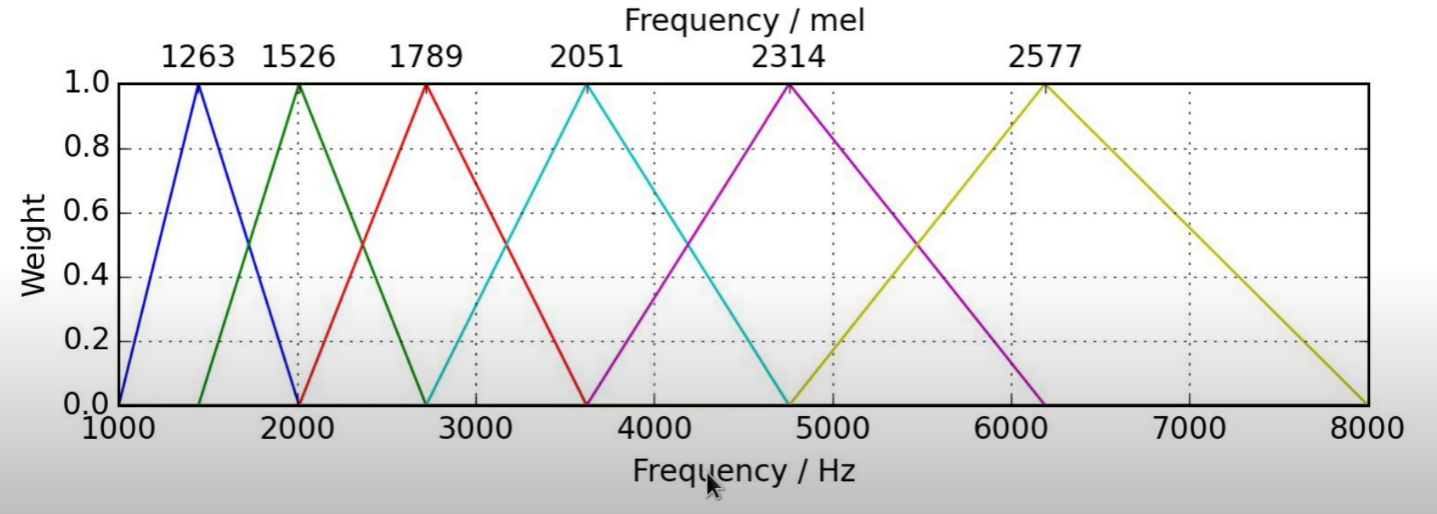
